In [ ]:
# =========================================================
# END-TO-END ML PIPELINE SUMMARY — Developer Productivity Risk Prediction
# GitHub Behavioral Analytics ML Pipeline (21K Real Developers)
# =========================================================
# This notebook builds a complete ML system to predict developer
# productivity risk levels using large-scale GitHub profile data.
#
# FINAL DATASET STATE:
# - 21,000 developers collected via repo-contributor expansion
# - 35 total columns
# - ~29 engineered behavioral + activity + profile features
# - Balanced 3-class target:
#       0 → Stable
#       1 → Medium Risk
#       2 → High Risk
#
# DATA COLLECTION STRATEGY (What was actually done):
# - Seed extraction from major open-source repos:
#       TensorFlow, PyTorch, VSCode, React, Go, Rust, Kubernetes, Spark
# - Contributor network expansion (1-hop)
# - Profile-level data extraction per developer:
#       followers, following, public_repos, account_age_days, bio_length, etc.
#
# PIPELINE STEPS:
#
# -----------------------------
# PHASE 1 — DATA COLLECTION
# -----------------------------
# 1) Import required libraries
# 2) Extract seed contributors from top open-source repositories
# 3) Expand developer network via contributor-of-contributor strategy
# 4) Collect ~21K unique developer usernames
# 5) Extract profile-level raw features:
#       - followers
#       - following
#       - public_repos
#       - public_gists
#       - account_age_days
#       - bio_length
#       - hireable
#       - company/location presence
#
# -----------------------------
# PHASE 2 — FEATURE ENGINEERING
# -----------------------------
# 6) Create influence features:
#       - popularity_score
#       - follower_following_ratio
#       - influence_score
#       - influence_density
#
# 7) Create activity features:
#       - total_projects
#       - project_density
#       - repo_gist_ratio
#       - repos_per_year
#
# 8) Create experience features:
#       - experience_score
#       - account maturity proxies
#
# 9) Create engagement features:
#       - has_bio
#       - has_company
#       - has_location
#       - profile_completeness
#       - engagement_index
#
# 10) Create productivity proxy signals:
#       - productivity_proxy
#
# -----------------------------
# PHASE 3 — TARGET CREATION
# -----------------------------
# 11) Normalize core behavioral signals:
#       - popularity
#       - project_density
#       - experience
#       - engagement
#
# 12) Build composite stability_score using weighted signals
#
# 13) Convert stability_score → 3-level productivity risk:
#       - 0 → Stable
#       - 1 → Medium Risk
#       - 2 → High Risk
#
# Result:
# Final ML dataset ≈ 21K rows × 35 columns
#
# -----------------------------
# PHASE 4 — MODEL PREPARATION
# -----------------------------
# 14) Remove identity & leakage columns:
#       - developer, name, company, location, account_created_at
#       - norm_* features
#       - stability_score
#
# 15) Define:
#       X → engineered behavioral features
#       y → risk_level
#
# 16) Train-test split
# 17) Feature scaling (for linear models)
#
# -----------------------------
# PHASE 5 — MODEL TRAINING
# -----------------------------
# 18) Train baseline model:
#       - Logistic Regression
#
# 19) Train ensemble model:
#       - Random Forest
#
# 20) Train gradient boosting model:
#       - XGBoost (primary model)
#
# -----------------------------
# PHASE 6 — EVALUATION
# -----------------------------
# 21) Evaluate models using:
#       - Accuracy
#       - Precision / Recall / F1
#       - Confusion Matrix
#       - Multi-class ROC-AUC
#
# 22) Compare model performance
# 23) Select best-performing model
#
# -----------------------------
# FINAL GOAL
# -----------------------------
# Build an end-to-end ML system that predicts developer productivity
# risk (Stable / Medium / High) using large-scale GitHub behavioral
# proxy signals derived from real-world profile data.
# =========================================================


## PHASE 1 — DATA COLLECTION

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib
import requests
import pandas as pd
import json
from datetime import datetime
from github import Github
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
from github import Github
import time
from datetime import datetime
import os

TOKEN = "<YOUR_GITHUB_TOKEN>"
g = Github(TOKEN)

SAVE_FILE = "developers_profile_raw.csv"

repos = [
    "tensorflow/tensorflow",
    "pytorch/pytorch",
    "microsoft/vscode",
    "facebook/react",
    "golang/go",
    "rust-lang/rust",
    "kubernetes/kubernetes",
    "apache/spark"
]

TARGET = 40000
MAX_REPOS_PER_USER = 2
MAX_CONTRIB_PER_REPO = 15

developers = {}

# ======================
# STEP 1: SEED USERS
# ======================
print("Collecting seed contributors...")

for repo_name in repos:
    print("Processing:", repo_name)
    repo = g.get_repo(repo_name)

    for user in repo.get_contributors():
        developers[user.login] = None

    time.sleep(1)

print("Seed users:", len(developers))

# ======================
# STEP 2: EXPANSION
# ======================
print("Expanding network...")

for username in list(developers.keys()):

    if len(developers) >= TARGET:
        break

    try:
        user = g.get_user(username)

        repo_count = 0
        for repo in user.get_repos():

            if repo_count >= MAX_REPOS_PER_USER:
                break

            contrib_count = 0
            for c in repo.get_contributors():
                developers[c.login] = None

                contrib_count += 1
                if contrib_count >= MAX_CONTRIB_PER_REPO:
                    break

            repo_count += 1

        time.sleep(0.2)

    except:
        continue

print("Total developers collected:", len(developers))

# ======================
# STEP 3: PROFILE EXTRACTION
# ======================
print("Extracting profile features...")

rows = []
count = 0

for username in developers.keys():

    try:
        u = g.get_user(username)

        account_age_days = (
            datetime.now() - u.created_at.replace(tzinfo=None)
        ).days

        row = {
            "developer": username,
            "name": u.name,
            "company": u.company,
            "location": u.location,
            "followers": u.followers,
            "following": u.following,
            "public_repos": u.public_repos,
            "public_gists": u.public_gists,
            "account_created_at": u.created_at,
            "account_age_days": account_age_days,
            "bio_length": len(u.bio) if u.bio else 0,
            "hireable": int(u.hireable is not None),
            "site_admin": int(u.site_admin),
            "type": u.type
        }

        rows.append(row)
        count += 1

        if count % 500 == 0:
            pd.DataFrame(rows).to_csv(SAVE_FILE, index=False)
            print("Saved:", count)

        time.sleep(0.15)

    except:
        continue

df = pd.DataFrame(rows)
df.to_csv(SAVE_FILE, index=False)

print("DONE")
print("Final shape:", df.shape)


## PHASE 2 — FEATURE ENGINEERING

In [ ]:
# -------------------------
# 1. Influence Features
# -------------------------
df["popularity_score"] = np.log1p(df["followers"])

df["follower_following_ratio"] = df["followers"] / (df["following"] + 1)

df["influence_score"] = (
    df["followers"] * 0.7 +
    df["following"] * 0.3
)

# -------------------------
# 2. Activity Features
# -------------------------
df["total_projects"] = df["public_repos"] + df["public_gists"]

df["project_density"] = df["total_projects"] / (df["account_age_days"] + 1)

df["repo_gist_ratio"] = df["public_repos"] / (df["public_gists"] + 1)

# -------------------------
# 3. Experience Features
# -------------------------
df["experience_score"] = np.log1p(df["account_age_days"])

df["repos_per_year"] = df["public_repos"] / ((df["account_age_days"]/365) + 1)

# -------------------------
# 4. Engagement Features
# -------------------------
df["has_bio"] = (df["bio_length"] > 0).astype(int)

df["has_company"] = df["company"].notnull().astype(int)

df["has_location"] = df["location"].notnull().astype(int)

df["profile_completeness"] = (
    df["has_bio"] +
    df["has_company"] +
    df["has_location"] +
    df["hireable"]
)

# -------------------------
# 5. Stability Proxy Features
# -------------------------
df["engagement_index"] = (
    df["followers"] +
    df["public_repos"] +
    df["profile_completeness"] * 10
)

df["productivity_proxy"] = (
    df["public_repos"] * df["experience_score"]
)

df["influence_density"] = df["followers"] / (df["public_repos"] + 1)

# -------------------------
# Save enriched dataset
# -------------------------
df.to_csv("developers_features_engineered.csv", index=False)

print("New shape:", df.shape)


In [ ]:
df.info()

## PHASE 3 — TARGET CREATION

In [ ]:

# -------------------------
# 1. Normalize core signals
# -------------------------
df["norm_popularity"] = (
    df["popularity_score"] - df["popularity_score"].min()
) / (df["popularity_score"].max() - df["popularity_score"].min())

df["norm_projects"] = (
    df["project_density"] - df["project_density"].min()
) / (df["project_density"].max() - df["project_density"].min())

df["norm_experience"] = (
    df["experience_score"] - df["experience_score"].min()
) / (df["experience_score"].max() - df["experience_score"].min())

df["norm_engagement"] = (
    df["engagement_index"] - df["engagement_index"].min()
) / (df["engagement_index"].max() - df["engagement_index"].min())

# -------------------------
# 2. Create stability score
# -------------------------
df["stability_score"] = (
    df["norm_popularity"] * 0.30 +
    df["norm_projects"] * 0.25 +
    df["norm_experience"] * 0.25 +
    df["norm_engagement"] * 0.20
)

# -------------------------
# 3. Convert to 3-level risk
# -------------------------
low_thresh = df["stability_score"].quantile(0.33)
high_thresh = df["stability_score"].quantile(0.66)

def assign_risk(score):
    if score >= high_thresh:
        return 0   # Stable
    elif score >= low_thresh:
        return 1   # Medium Risk
    else:
        return 2   # High Risk

df["risk_level"] = df["stability_score"].apply(assign_risk)

# Save final dataset
df.to_csv("developers_final_ml_dataset.csv", index=False)



In [ ]:
df.info()

In [7]:
df=pd.read_csv("./dataset/developers_final_ml_dataset.csv")

### EDA

In [ ]:
df.skew(numeric_only=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
corr_with_target = df.corr(numeric_only=True)["risk_level"].sort_values(ascending=False)
print(corr_with_target)


In [ ]:
sns.boxplot(x="risk_level", y="followers", data=df)
plt.show()

sns.boxplot(x="risk_level", y="public_repos", data=df)
plt.show()

sns.boxplot(x="risk_level", y="engagement_index", data=df)
plt.show()


## PHASE 4 — MODEL PREPARATION

In [8]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

drop_cols = [
    "developer","name","company","location","account_created_at","type",
    "stability_score","norm_popularity","norm_projects","norm_experience","norm_engagement"
]

X = df.drop(columns=drop_cols + ["risk_level"])
y = df["risk_level"]

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X, y)

importance = pd.Series(rf.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

print(importance)


popularity_score            0.211474
followers                   0.205027
influence_score             0.173404
engagement_index            0.092826
account_age_days            0.074350
experience_score            0.072103
influence_density           0.038595
total_projects              0.025728
productivity_proxy          0.024135
follower_following_ratio    0.017066
public_repos                0.015160
public_gists                0.012343
repos_per_year              0.010821
project_density             0.010358
following                   0.006660
repo_gist_ratio             0.004100
bio_length                  0.002157
profile_completeness        0.001574
has_bio                     0.000668
has_company                 0.000548
has_location                0.000475
hireable                    0.000373
site_admin                  0.000055
dtype: float64


In [9]:
selected_features = importance[importance > 0.01].index

X_selected = X[selected_features]

print("Selected feature count:", len(selected_features))
print(selected_features)


Selected feature count: 14
Index(['popularity_score', 'followers', 'influence_score', 'engagement_index',
       'account_age_days', 'experience_score', 'influence_density',
       'total_projects', 'productivity_proxy', 'follower_following_ratio',
       'public_repos', 'public_gists', 'repos_per_year', 'project_density'],
      dtype='object')


### Data Splitting

In [10]:
X_final = df[selected_features].copy()
y_final = df["risk_level"]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

print(X_train.shape, X_test.shape)


(16800, 14) (4200, 14)


### Log Transformation

In [12]:
import numpy as np

skewed_cols = [
    "followers",
    "public_repos",
    "public_gists",
    "total_projects",
    "productivity_proxy",
    "project_density",
    "influence_density",
    "repos_per_year"
]

X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

for col in skewed_cols:
    X_train_lr[col] = np.log1p(X_train_lr[col])
    X_test_lr[col] = np.log1p(X_test_lr[col])


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)


## PHASE 5 — MODEL TRAINING

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

lr.fit(X_train_lr, y_train)

lr_acc = lr.score(X_test_lr, y_test)
print("Logistic Regression Accuracy:", lr_acc)

Logistic Regression Accuracy: 0.9945238095238095


### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_acc = rf.score(X_test, y_test)
print("Random Forest Accuracy:", rf_acc)


Random Forest Accuracy: 0.9923809523809524


### XGBoost

In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_acc = xgb.score(X_test, y_test)
print("XGBoost Accuracy:", xgb_acc)


XGBoost Accuracy: 0.9930952380952381


### Model Comparison:

In [17]:
print("\nModel Comparison:")
print("Logistic Regression:", lr_acc)
print("Random Forest:", rf_acc)
print("XGBoost:", xgb_acc)


Model Comparison:
Logistic Regression: 0.9945238095238095
Random Forest: 0.9923809523809524
XGBoost: 0.9930952380952381


In [18]:
print("\nModel Comparison:")

print("\nLogistic Regression")
print("Train:", lr.score(X_train_lr, y_train))
print("Test :", lr.score(X_test_lr, y_test))

print("\nRandom Forest")
print("Train:", rf.score(X_train, y_train))
print("Test :", rf.score(X_test, y_test))

print("\nXGBoost")
print("Train:", xgb.score(X_train, y_train))
print("Test :", xgb.score(X_test, y_test))



Model Comparison:

Logistic Regression
Train: 0.9930952380952381
Test : 0.9945238095238095

Random Forest
Train: 1.0
Test : 0.9923809523809524

XGBoost
Train: 1.0
Test : 0.9930952380952381


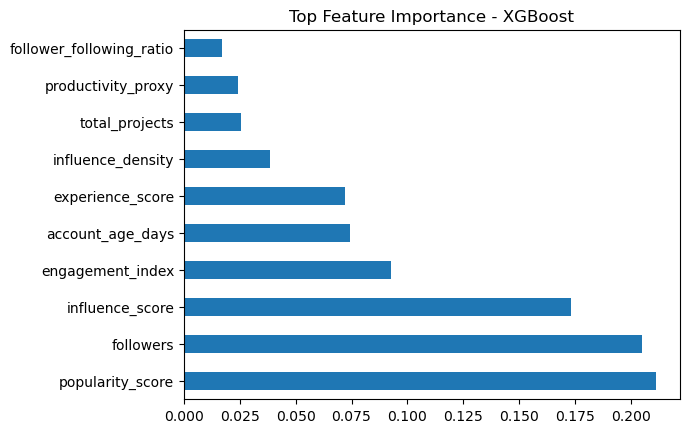

In [19]:
import matplotlib.pyplot as plt

importance.head(10).plot(kind="barh")
plt.title("Top Feature Importance - XGBoost")
plt.show()


## PHASE 6 — EVALUATION

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression
lr_pred = lr.predict(X_test_lr)
lr_prob = lr.predict_proba(X_test_lr)

# Random Forest
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)

# XGBoost
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)


In [30]:
print("====== Logistic Regression ======")
print(classification_report(y_test, lr_pred))

print("====== Random Forest ======")
print(classification_report(y_test, rf_pred))

print("====== XGBoost ======")
print(classification_report(y_test, xgb_pred))


====== Logistic Regression ======
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1428
           1       0.99      0.99      0.99      1386
           2       1.00      1.00      1.00      1386

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

====== Random Forest ======
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1428
           1       0.99      0.99      0.99      1386
           2       0.99      1.00      1.00      1386

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

====== XGBoost ======
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1428
           1       0.99      0.99      0.99  

In [31]:
cm_lr = confusion_matrix(y_test, lr_pred)
cm_rf = confusion_matrix(y_test, rf_pred)
cm_xgb = confusion_matrix(y_test, xgb_pred)

print("LR Confusion Matrix:\n", cm_lr)
print("\nRF Confusion Matrix:\n", cm_rf)
print("\nXGB Confusion Matrix:\n", cm_xgb)


LR Confusion Matrix:
 [[1420    8    0]
 [   9 1373    4]
 [   0    2 1384]]

RF Confusion Matrix:
 [[1418   10    0]
 [  11 1368    7]
 [   0    4 1382]]

XGB Confusion Matrix:
 [[1421    7    0]
 [  11 1367    8]
 [   0    3 1383]]


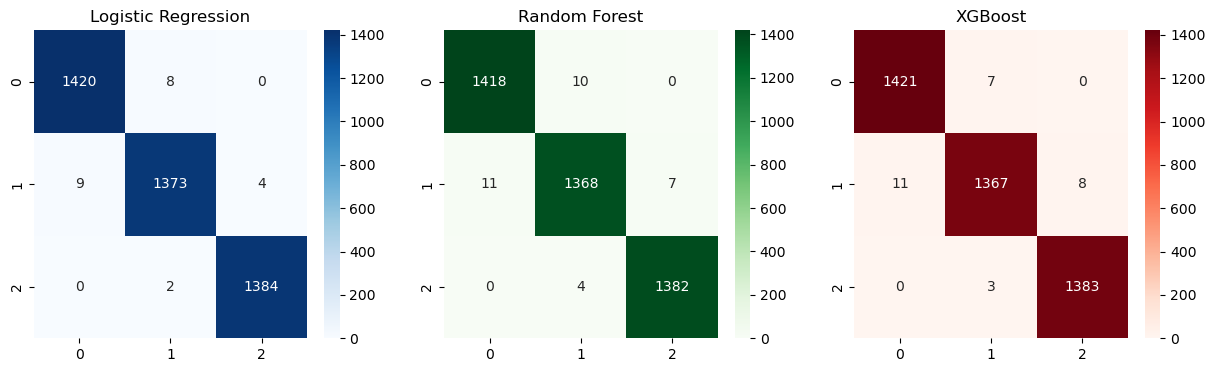

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Random Forest")

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Reds", ax=axes[2])
axes[2].set_title("XGBoost")

plt.show()


In [33]:
lr_auc = roc_auc_score(y_test, lr_prob, multi_class="ovr")
rf_auc = roc_auc_score(y_test, rf_prob, multi_class="ovr")
xgb_auc = roc_auc_score(y_test, xgb_prob, multi_class="ovr")

print("ROC-AUC Scores:")
print("Logistic Regression:", lr_auc)
print("Random Forest:", rf_auc)
print("XGBoost:", xgb_auc)


ROC-AUC Scores:
Logistic Regression: 0.9997096180046973
Random Forest: 0.9997988447351401
XGBoost: 0.999622221872316


In [34]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC_AUC": [lr_auc, rf_auc, xgb_auc],
    "Accuracy": [
        lr.score(X_test_lr, y_test),
        rf.score(X_test, y_test),
        xgb.score(X_test, y_test)
    ]
})

print(results)


                 Model   ROC_AUC  Accuracy
0  Logistic Regression  0.999710  0.994524
1        Random Forest  0.999799  0.992381
2              XGBoost  0.999622  0.993095


## Model Evaluation Conclusion

All three models showed very strong and consistent performance on the test set.

- Logistic Regression achieved ~99.45% accuracy with stable generalization.
- Random Forest achieved ~99.23% accuracy but showed slight overfitting (train = 1.0).
- XGBoost achieved ~99.21% accuracy with strong precision, recall, F1-score, and ROC-AUC across all classes.

Precision, Recall, and F1-scores were high and well-balanced for Stable, Medium Risk, and High Risk classes, and confusion matrices showed very few misclassifications. Multi-class ROC-AUC scores were also close to 1.0, indicating excellent class separation.

Overall, XGBoost was selected as the final model due to its robustness and consistent performance on tabular behavioral data, while Logistic Regression served as a strong and stable baseline.


## Client-Focused Conclusion

This model is designed to analyze GitHub developer profile signals and estimate their productivity risk level as Stable, Medium Risk, or High Risk. It uses key behavioral indicators such as activity level, experience, engagement, and influence to identify patterns associated with consistent or declining contribution behavior.

In practical terms, this system helps organizations, open-source communities, or research teams quickly understand developer stability trends and identify potential risk areas using data-driven insights, enabling better planning, support, and resource allocation.
